# Milestone 2: Generative Modeling with GANs (EEG Data Augmentation)

**Objective:**
Design and implement a Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP) to learn the distribution of EEG segments and generate synthetic EEG data conditioned on an emotion label (e.g. “positive” or “negative”). This synthetic data can later be used to augment your limited EEG dataset.

**Why have we decided to go with this approach of Conditional Wasserstein GAN?**
The rationale is based on the research of these papers.
- [Deep Convolutional Neural Network-Based Visual Stimuli Classification Using Electroencephalography Signals of Healthy and Alzheimer’s Disease Subjects](https://pmc.ncbi.nlm.nih.gov/articles/PMC8950142/)
- [Generative adversarial networks in EEG analysis: an overview](https://jneuroengrehab.biomedcentral.com/articles/10.1186/s12984-023-01169-w)
- [Data Augmentation for EEG-Based Emotion Recognition Using Generative Adversarial Networks](https://www.frontiersin.org/journals/computational-neuroscience/articles/10.3389/fncom.2021.723843/full)

we already had some initial research on why GAN's work, which is more detailed on the Frintiers paper above, but because of the conditional WGAN results on augmentation of emotion EEG data, we chose this approach.

**Research question overview**
- Can deep generative models produce realistic EEG signals in both the time and frequency domains?
- Does conditioning on the class label allow generation of class-specific patterns (i.e., can we generate EEG that resembles “positive” vs. “negative” emotion)?


**Team Contributions:**
- **Rahul:** Overall project integration, detailed documentation, and Implementation of the GAN models and training loop.
- **Aarohi:** Evaluation, and improvement, with an additional help in research.

In this notebook, we have:
1. Defined the generator and discriminator architectures (adapted for multichannel time-series EEG).
2. Implemented the WGAN-GP training loop.
3. Visualized training progress and sample outputs.
4. Explained why we did, what we did I guess.

In [15]:
# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import mne
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.signal import welch
import matplotlib
%matplotlib inline
import seaborn as sns

# Set the aesthetic style for plots
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.2)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Hyperparameters and Data Dimensions

we define key hyperparameters, such as the latent dimension, number of channels, signal length, number of classes

- **latent_dim:** 100
- **n_channels:** 63
- **signal_len:** 1000 (5 sec at 200 Hz)
- **num_classes:** 2

also set training hyperparameters

In [2]:
latent_dim = 100
n_channels = 63
signal_len = 1000    # 5 seconds at 200 Hz
num_classes = 2

batch_size = 64
learning_rate = 5e-5
lambda_gp = 10
num_epochs = 10000   #This for a full training, can be less for testing

### GAN Architectures

I now define our **Generator** and **Discriminator**. Since our EEG epochs are 63 channels × 1000 samples, we adjust the network accordingly.

**Generator:**
- Input: A noise vector (100-D) concatenated with a one-hot encoded label (2-D).
- Fully-connected layer: Projects the combined vector to a feature map of size 256 × (signal_len/8). I use `signal_len // 8` because with 3 transposed convolution layers (each with stride=2) we upscale from 125 to 250 to 500 to 1000 samples. Once testing out this approach, we identified that some EEG epochs did not follow this upscaling because of timestamps, We then defined our generator to produce epochs of exactly target_signal_len timepoints. The generator first computes a base length: target_signal_len // 8 (since we upsample by a factor of 8 over 3 ConvTranspose1d layers). Then it calculates the remainder: target_signal_len - base_length*8. Finally, in the last ConvTranspose1d layer we set output_padding=remainder, so that the final output has the correct length.
For example, if target_signal_len = 1001, then base_length = 125 (since 125*8 = 1000) and remainder = 1.

**Discriminator:**
- Input: An EEG epoch with shape (63, 1000) plus a label appended as extra channels.
- Uses 1D convolution layers to downsample the signal and produce a scalar score.


In [3]:
class EEGGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_channels=63, target_signal_len=1001, num_classes=2):
        super().__init__()
        self.n_channels = n_channels
        self.target_signal_len = target_signal_len
        self.num_classes = num_classes

        # Compute base length and remainder for upsampling:
        self.base_length = target_signal_len // 8
        remainder = target_signal_len - (self.base_length * 8)

        # Fully connected layer to project latent noise + label to a feature map of shape (256, base_length)
        self.fc = nn.Linear(latent_dim + num_classes, 256 * self.base_length)

        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            # We add output_padding equal to the remainder (which is 1 if target_signal_len==1001)
            nn.ConvTranspose1d(64, n_channels, kernel_size=4, stride=2, padding=1, output_padding=remainder),
            nn.Tanh()  # Output is between -1 and 1.
        )
    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 256, self.base_length)
        out = self.deconv_blocks(x)
        return out

In [4]:
class EEGDiscriminator(nn.Module):
    def __init__(self, n_channels=63, signal_len=1000, num_classes=2):
        super().__init__()
        self.n_channels = n_channels
        self.signal_len = signal_len
        self.num_classes = num_classes

        # The discriminator takes EEG data with shape (n_channels, signal_len)
        # We add the label as extra channels; so the input channel dimension becomes (n_channels + num_classes)
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(n_channels + num_classes, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, eeg, labels):
        # Expand label vector
        label_expand = labels.unsqueeze(2).repeat(1, 1, eeg.shape[2])
        # Concatenate along channel dimension
        d_in = torch.cat([eeg, label_expand], dim=1)
        out = self.conv_blocks(d_in)
        # Global average pooling over the time dimension to get a scalar per sample
        return out.mean(dim=2)

### Load Preprocessed EEG Data

Here I load the preprocessed EEG epochs produced by our `preprocessor_all_data.py` module. I am loading all subjects, extract the epoch data and create one-hot encoded labels for binary classification.


In [5]:
def load_all_preprocessed_data(preprocessed_root="./../data/preprocessed/"):
    subject_folders = [d for d in os.listdir(preprocessed_root) if os.path.isdir(os.path.join(preprocessed_root, d))]
    all_data = []
    all_labels = []

    for subj in subject_folders:
        fif_path = os.path.join(preprocessed_root, subj, "preprocessed_epochs-epo.fif")
        if os.path.exists(fif_path):
            epochs = mne.read_epochs(fif_path, preload=True)
            data = epochs.get_data()
            events = epochs.events


            labels_int = events[:, 2]
            unique_codes = np.unique(labels_int)

            # If only one event code is found, randomly split epochs into two classes.
            if len(unique_codes) < 2:
                print(f"Subject {subj}: Only one event code found. Randomly splitting epochs into two classes.")
                n_epochs = data.shape[0]
                # Randomly shuffle indices and split into two halves.
                indices = np.arange(n_epochs)
                np.random.shuffle(indices)
                labels_int = np.zeros(n_epochs, dtype=int)
                split_idx = n_epochs // 2
                labels_int[indices[split_idx:]] = 1
            else:
                # If more than two codes, take only the first two
                if len(unique_codes) > 2:
                    unique_codes = unique_codes[:2]
                mapping = {unique_codes[0]: 0, unique_codes[1]: 1}
                labels_int = np.vectorize(lambda x: mapping.get(x, 0))(labels_int)

            # One-hot encode the labels
            labels_onehot = np.zeros((len(labels_int), num_classes))
            labels_onehot[np.arange(len(labels_int)), labels_int] = 1

            all_data.append(data)
            all_labels.append(labels_onehot)
        else:
            print(f"File {fif_path} not found. Skipping subject {subj}.")

    if len(all_data) == 0:
        raise RuntimeError("No preprocessed data found.")

    # Concatenate data across subjects
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print("Loaded preprocessed EEG data shape:", all_data.shape)
    print("Loaded labels shape:", all_labels.shape)
    return all_data, all_labels

In [6]:
# load all the data
all_data, all_labels = load_all_preprocessed_data()

Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/Exploratory notebooks/../data/preprocessed/Sub42/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Subject Sub42: Only one event code found. Randomly splitting epochs into two classes.
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/Exploratory notebooks/../data/preprocessed/Sub11/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Subject Sub11: Only one event code found. Randomly splitting epochs into two classes.
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/

In [7]:
# Convert data to torch tensors (ensure float32 for EEG and float32 for labels)
real_EEG = torch.from_numpy(all_data.astype(np.float32))
real_labels = torch.from_numpy(all_labels.astype(np.float32))
print("Torch EEG data shape:", real_EEG.shape)
print("Torch labels shape:", real_labels.shape)

Torch EEG data shape: torch.Size([901, 63, 1001])
Torch labels shape: torch.Size([901, 2])


### Instantiate Models and Optimizers


In [8]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for windows
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# Set target signal length based on real data
target_signal_len = real_EEG.shape[2]
print("Target signal length:", target_signal_len)

# Instantiate generator and discriminator accordingly
generator = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)
discriminator = EEGDiscriminator(n_channels, target_signal_len, num_classes).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))

Using device: mps
Target signal length: 1001


In [9]:
# Create a DataLoader
dataset = TensorDataset(real_EEG, real_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Gradient Penalty Function for WGAN-GP

This function computes the gradient penalty required for WGAN-GP.

In [10]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

### Training Loop for Conditional WGAN-GP

For each batch, we:
1. Update the discriminator n_critic times by comparing its outputs on real and fake EEG, plus the gradient penalty.
2. Update the generator by maximizing the discriminator's output on fake EEG.

We record losses to monitor training progress.

In [11]:
n_critic = 5  # Discriminator updates per generator update
G_losses = []
D_losses = []

print("Starting training...")

# Use tqdm for the epochs loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    for i, (real_batch, labels) in enumerate(dataloader):
        real_batch = real_batch.to(device)
        labels = labels.to(device)
        current_batch_size = real_batch.size(0)

        # --- Update Discriminator ---
        for _ in range(n_critic):
            noise = torch.randn(current_batch_size, latent_dim).to(device)
            fake_EEG = generator(noise, labels)

            D_real = discriminator(real_batch, labels)
            D_fake = discriminator(fake_EEG.detach(), labels)
            gp = compute_gradient_penalty(discriminator, real_batch, fake_EEG.detach(), labels)
            D_loss = D_fake.mean() - D_real.mean() + lambda_gp * gp

            optimizer_D.zero_grad()
            D_loss.backward()
            optimizer_D.step()

        # --- Update Generator ---
        noise = torch.randn(current_batch_size, latent_dim).to(device)
        fake_EEG = generator(noise, labels)
        G_loss = -discriminator(fake_EEG, labels).mean()

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

print("Training complete.")

Starting training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/500] | D_loss: -424.4608 | G_loss: 69.2524
Epoch [40/500] | D_loss: -566.1940 | G_loss: -225.3786
Epoch [60/500] | D_loss: -336.9853 | G_loss: -631.5655
Epoch [80/500] | D_loss: -169.7093 | G_loss: -610.2904
Epoch [100/500] | D_loss: -164.0422 | G_loss: -452.6214
Epoch [120/500] | D_loss: -146.4005 | G_loss: -630.0366
Epoch [140/500] | D_loss: -195.9338 | G_loss: -1021.4207
Epoch [160/500] | D_loss: -281.1906 | G_loss: -1613.0583
Epoch [180/500] | D_loss: -337.5422 | G_loss: -2592.9060
Epoch [200/500] | D_loss: -311.5933 | G_loss: -3561.0911
Epoch [220/500] | D_loss: -408.8030 | G_loss: -4364.5532
Epoch [240/500] | D_loss: -444.1556 | G_loss: -5302.3828
Epoch [260/500] | D_loss: -450.2510 | G_loss: -6074.1763
Epoch [280/500] | D_loss: -427.6338 | G_loss: -6643.6953
Epoch [300/500] | D_loss: -526.4328 | G_loss: -7002.1968
Epoch [320/500] | D_loss: -405.0876 | G_loss: -6652.1636
Epoch [340/500] | D_loss: -430.5752 | G_loss: -6181.9321
Epoch [360/500] | D_loss: -222.2010 | G_los

### Plot Training Losses

Plot the evolution of generator and discriminator losses to assess training stability.

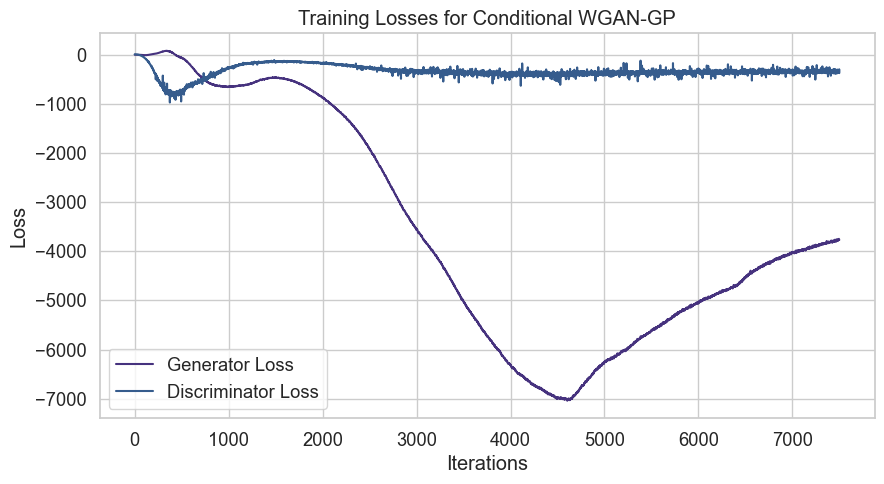

In [12]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Losses for Conditional WGAN-GP")
plt.legend()
plt.show()

### Generate and Evaluate Synthetic EEG Samples

Now, we generate synthetic EEG epochs for a given class (e.g., label 0: “positive”) and visualize:
- Time-domain waveforms (for a subset of channels)
- Power Spectral Density (PSD) for one sample to check frequency content.

This evaluation helps answer whether the GAN produces realistic EEG signals and respects class conditioning.


In [13]:
def generate_samples(generator, num_samples, label_int):
    labels = torch.zeros(num_samples, num_classes).to(device)
    labels[:, label_int] = 1
    noise = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        fake_samples = generator(noise, labels)
    return fake_samples.cpu().numpy()

# Generate 4 samples for label 0 ("positive")
fake_samples = generate_samples(generator, 4, label_int=0)

#### Time-Domain Visualization

Plot a couple of generated EEG epochs (only first 8 channels) to inspect the waveform morphology.

/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_18190/65182783.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize="small")


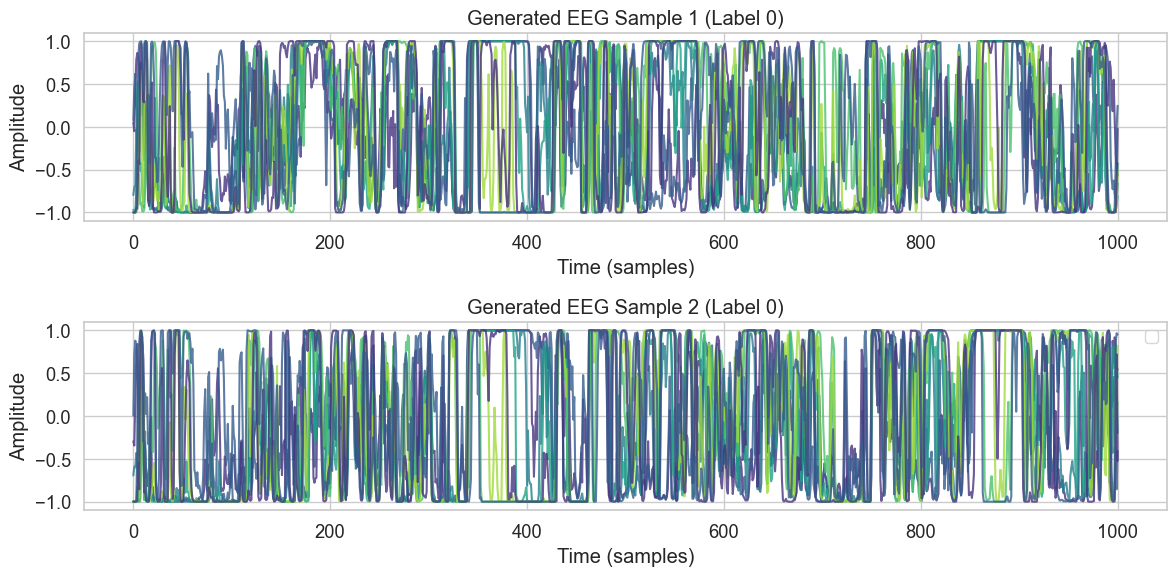

In [14]:
num_to_plot = 2
plt.figure(figsize=(12, 6))
for i in range(num_to_plot):
    plt.subplot(num_to_plot, 1, i+1)
    for ch in range(8):
        plt.plot(fake_samples[i, ch, :], label=f"Ch {ch}" if i==0 else "", alpha=0.8)
    plt.title(f"Generated EEG Sample {i+1} (Label 0)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.legend(loc="upper right", fontsize="small")
plt.show()

#### Power Spectral Density (PSD)

For one generated sample (channel 0), compute the PSD using Welch's method. We expect an EEG-like spectrum (with a 1/f trend and characteristic peaks).


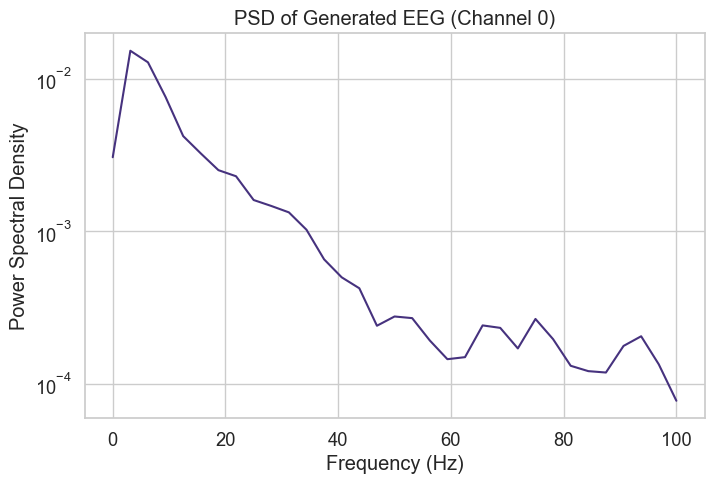

In [16]:
fs_generated = 200  # Sampling frequency
sample_idx = 0
channel_idx = 0
signal_data = fake_samples[sample_idx, channel_idx, :]

freqs, psd = welch(signal_data, fs=fs_generated, nperseg=64)

plt.figure(figsize=(8,5))
plt.semilogy(freqs, psd)
plt.title("PSD of Generated EEG (Channel 0)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.show()